In [1]:
# Notebook
%matplotlib inline
import matplotlib.pyplot as plt
import sys
import numpy as np
from text_tokenizer import tokenize

# ==== CONFIGS ====

h5_save_as = "models/lstm-nolimit-cbow-100d.h5"

# The word vector can be swapped with say GoogleNews 6B dataset
word_vector_bin_file = "word2vec/w2v-imdb-cbow-100d.bin"
word_vector_dims = 100

# Can easily swap with other datasets if you want
positive_review_txts = "aclImdb/train/pos/*.txt"
negative_review_txts = "aclImdb/train/neg/*.txt"
positive_review_vals = "aclImdb/test/pos/*.txt"
negative_review_vals = "aclImdb/test/neg/*.txt"

pad_token = '<PAD/>'
positive_y = [1, 0]
negative_y = [0, 1]

## Step 1: Make X_train

X_train data structure is a 3D array, consisting of reviews, words, and vectors:
```json
[
  // a review
  [
    // a word, and its array of 100 vectors
    [0.75, 0.64 ...],
    ...
  ], 
  ...
]
```

### TODO:
1. Load all the reviews into memory
2. Normalize the text
3. Add words to vocab array to make word vector retrieval faster
3. Determine vocab size, max review length

In [2]:
import glob

# highest word count shall be the convnet rows
highest_review_word_count = 0
training_reviews = []
validating_reviews = []

# just for notebook
file_read_count = 0

for txt in glob.glob(positive_review_txts):
    with (open(txt, 'r')) as f:
        word_array =  tokenize(f.read())
        highest_review_word_count = max(highest_review_word_count, len(word_array))
        training_reviews.append([word_array, positive_y])
        file_read_count += 1
        if file_read_count % 1000 == 0:
            sys.stdout.write("\r{0}".format(file_read_count))
            sys.stdout.flush()

for txt in glob.glob(negative_review_txts):
    with (open(txt, 'r')) as f:
        word_array = tokenize(f.read())
        highest_review_word_count = max(highest_review_word_count, len(word_array))
        training_reviews.append([word_array, negative_y])
        file_read_count += 1
        if file_read_count % 1000 == 0:
            sys.stdout.write("\r{0}".format(file_read_count))
            sys.stdout.flush()
        
# For validation purposes
for txt in glob.glob(positive_review_vals):
    with (open(txt, 'r')) as f:
        word_array = tokenize(f.read())
        validating_reviews.append([word_array, positive_y])
        file_read_count += 1
        if file_read_count % 1000 == 0:
            sys.stdout.write("\r{0}".format(file_read_count))
            sys.stdout.flush()

for txt in glob.glob(negative_review_vals):
    with (open(txt, 'r')) as f:
        word_array = tokenize(f.read())
        validating_reviews.append([word_array, negative_y])
        file_read_count += 1
        if file_read_count % 1000 == 0:
            sys.stdout.write("\r{0}".format(file_read_count))
            sys.stdout.flush()

print('highest word count: ', highest_review_word_count)

50000('highest word count: ', 2606)


## Step 2: Assign vector to vocabs

In [3]:
import sys
import gensim
from gensim.models import Word2Vec
word_vecs = Word2Vec.load_word2vec_format(word_vector_bin_file, binary=True)

Using gpu device 0: GeForce GTX 1060 6GB (CNMeM is disabled, cuDNN 5105)
/home/anonoz/anaconda2/envs/tensorflow/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


In [4]:
def word_vector_for(word):
    try:
        return np.array(word_vecs[word][:word_vector_dims])
    except KeyError:
        return np.random.uniform(-0.25, 0.25, word_vector_dims)

In [5]:
import random
from keras.preprocessing import sequence
# In this case, we will use a generator to generate these big ass numpy arrays on the fly.
# Considerations:
# - This generator must be an infinite loop
# - Every iteration must have shuffled data
#
#
# It will return a tuple of single X_train (sentence_length, dims) and Y_train (2,1)
#
def reviews_generator(reviews, batch_size=50):
    while 1:
        # Shuffle the reviews
        random.shuffle(reviews)
        
        batch_counter = 0
        x_train = []
        y_train = []
        for i, review in enumerate(reviews):
            x_train.append([word_vector_for(word) for j, word in enumerate(review[0])])
            y_train.append(review[1])
        
            if batch_counter + 1 == batch_size:
                x_train = sequence.pad_sequences(x_train, dtype='float32')
                y_train = np.array(y_train)
                yield x_train, y_train
                batch_counter = 0
                x_train = []
                y_train = []
            else:
                batch_counter += 1

Using Theano backend.


## Step 3: Keras


In [6]:
from keras.models import Model, Sequential
from keras.layers.convolutional import Convolution1D, Convolution2D
from keras.layers.pooling import MaxPooling1D, MaxPooling2D
from keras.layers.recurrent import LSTM
from keras.layers import Merge, Dense, Dropout, Activation, Input, Flatten
from keras.optimizers import SGD

In [7]:
final_model = Sequential()
final_model.add(LSTM(word_vector_dims,
                     input_shape=(None, word_vector_dims),
                     activation='sigmoid',
                     inner_activation='hard_sigmoid'))
final_model.add(Dense(2))
final_model.add(Activation('softmax'))

final_model.compile(loss='binary_crossentropy',
                    optimizer='adam',
                    metrics=['accuracy'])


## Step 4: TRAIN THIS

In [8]:
training_history = final_model.fit_generator(
  reviews_generator(training_reviews, batch_size=25),
  len(training_reviews),
  25,
  validation_data=reviews_generator(validating_reviews, batch_size=25),
  nb_val_samples=len(validating_reviews))

Epoch 1/25
25000/25000 [==============================] - 2186s - loss: 0.4698 - acc: 0.7633 - val_loss: 0.3195 - val_acc: 0.8671
Epoch 2/25
25000/25000 [==============================] - 2219s - loss: 0.3114 - acc: 0.8701 - val_loss: 0.3246 - val_acc: 0.8628
Epoch 3/25
25000/25000 [==============================] - 2211s - loss: 0.2774 - acc: 0.8848 - val_loss: 0.2708 - val_acc: 0.8876
Epoch 4/25
25000/25000 [==============================] - 2180s - loss: 0.2560 - acc: 0.8950 - val_loss: 0.3306 - val_acc: 0.8579
Epoch 5/25
25000/25000 [==============================] - 2187s - loss: 0.2397 - acc: 0.9041 - val_loss: 0.2626 - val_acc: 0.8903
Epoch 6/25
25000/25000 [==============================] - 2180s - loss: 0.2241 - acc: 0.9098 - val_loss: 0.2579 - val_acc: 0.8924
Epoch 7/25
25000/25000 [==============================] - 2168s - loss: 0.2108 - acc: 0.9156 - val_loss: 0.2601 - val_acc: 0.8940
Epoch 8/25
25000/25000 [==============================] - 2178s - loss: 0.1983 - acc: 0.92

## Step 5: Analyze Val Acc / Epoch

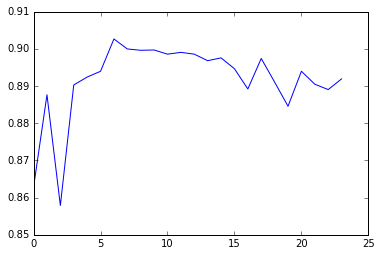

In [9]:
import matplotlib.pyplot as plt
plt.plot(training_history.history['val_acc'][1:])

In [10]:
final_model.save(h5_save_as)

## Step 5: Custom Predict

Will implement for small bit of text prediction later.

Somehow the predictions are dead wrong here.

In [15]:
def test_predict(text):
    word_array = tokenize(text)
    word_vec_array = np.array([[word_vector_for(word) for word in word_array]])

    prediction = final_model.predict(word_vec_array)
    print(prediction)
#     if prediction[0] > prediction[1]:
#         return ['movie review is positive', prediction]
#     else:
#         return ['movie review is negative', prediction]

In [16]:
test_predict("this is very good")

[[ 0.97747886  0.02252112]]


In [17]:
test_predict("gosh this is just bad")

[[ 0.09682809  0.9031719 ]]


In [ ]:
test_predict("train to busan is one of the best value for money movie one can pay for")

In [ ]:
test_predict("Blackhat is not only disappointing, its embarrassing")

In [ ]:
test_predict('''
Suffers from inconsistencies, both technical and story wise. They change the shooting styles, cameras, fps, warmth/cold - for no apparent reasons at all. Feels like it's not clear what this movie "wants to be". The main character is supposed to be a "super-hacker" but doesn't do anything "super hack-y", just wanders around, shooting people, and nails the female protagonist. Doesn't have many hacking-scenes for a "hackers movie", has tons of boring gun-scenes instead, from some reason. The motivation of the villain was, not interesting. References many other "movie-cliches" (not in a good way). Severely lacks humor. The few jokes in it are really cheesy (yeah, it's not a comedy , but comic reliefs are important). Many of the audience members left the theater in the middle or before the end
''')

In [ ]:
test_predict('explosive summer flick that will keep you on the couch for hours')

In [ ]:
test_predict('why would anyone watch this?')

In [ ]:
test_predict('Some people walked out of this one, it\'s just that crap')

In [ ]:
test_predict('this is definitely the best flick from christopher nolan yet!')

In [ ]:
test_predict('i dug my eyes out')

In [ ]:
test_predict('this is the one you must watch this year')

In [ ]:
test_predict('touching love story indeed')

In [ ]:
test_predict('would love to lie on the grassfield and watch this with her again')

In [ ]:
test_predict('I bet there are more productive things to do than watching this film') # negative

In [ ]:
test_predict('I would have to dig my eyes out from the socket on this one') # negative

In [ ]:
# Inception IMDB 10/10
test_predict('''
What is the most resilient parasite? An Idea! Yes, Nolan has created something with his unbelievably, incredibly and god- gifted mind which will blow the minds of the audience away. The world premiere of the movie, directed by Hollywood's most inventive dreamers, was shown in London and has already got top notch reviews worldwide and has scored maximum points! Now the question arises what the movie has that it deserve all this?

Dom Cobb(Di Caprio) is an extractor who is paid to invade the dreams of various business tycoons and steal their top secret ideas. Cobb robs forcefully the psyche with practiced skill, though he's increasingly haunted by the memory of his late wife, Mal (Marion Cotillard), who has a nasty habit of showing up in his subconscious and wreaking havoc on his missions. Cobb had been involved so much in his heist work that he had lost his love!

But then, as fate had decided, a wealthy business man Saito( Ken Watanabe) hands over the responsibility of dissolving the empire of his business rival Robert Fischer Jr.(Cillian Murphy). But this time his job was not to steal the idea but to plant a new one: 'Inception'

Then what happens is the classic heist movie tradition. To carry out the the task, Cobb's 'brainiac' specialists team up again with him, Arthur (Joseph Gordon-Levitt), his longtime organizer; Tom Hardy (Eames), a "forger" who can shapeshift at will; and Yusuf (Dileep Rao), a powerful sedative supplier. 

There is only one word to describe the cinematography, the set designs and the special effects, and that is Exceptional! You don't just watch the scenes happening, you feel them. The movie is a real thrill ride. The action scenes are well picturised and the music by Hans Zimmer is electronically haunting. Never, in the runtime of the movie, you will get a chance to move your eyes from the screen to any other object.

Leonardo, who is still popularly known for Jack Dawson played by him in Titanic, should be relieved as his role as Dom Cobb will be remembered forever. His performance may or may not fetch him an Oscar but it will be his finest performance till date. The supporting cast too did an extraordinary work. Christopher Nolan, ah! what a man he is. His work is nothing less than a masterpiece and he deserves all the awards in the 'Best Director' category. If "Inception" is a metaphysical puzzle, it's also a metaphorical one: It's hard not to draw connections between Cobb's dream-weaving and Nolan's film making, intended to seduce us, mess with our heads and leave an ever-lasting impression.

To conclude, I would just say before your life ends, do yourself a favor by experiencing this exceptionally lucid classic created by Nolan! ''')

In [ ]:
# IMDB Suicide Squad 2/10
test_predict('''
I don't get the ratings here. This is a cut and dry poorly made movie and fans of the DC universe deserve better. I don't normally post my reviews here. But I have to share my take on this movie because it just wasn't good. I didn't even have to go into spoilers to show how terrible it is. Movie goers shouldn't mindlessly consume these films. Christopher Nolan set a high bar, but producers and studios need to step messing with auteurs and maybe we can get a quality DC movie:

There is nothing in Suicide Squad that shows any hope that an auteur filmmaker can do anything distinctive with the current cash cow of the Hollywood machine: the super hero movie. What Christopher Nolan once made his own has devolved into a predictable pastiche whose charms should be wearing thin on audiences. It doesn't help that the movie is also an example of how bad one of these films can be when it becomes watered down and designed to refrain from shaking up anything in the so-called DC Universe. Suicide Squad, a PG-13 film, was supposed to be DC's entry to rival Marvel's R-rated Deadpool. Even though Deadpool had its own problems as a self-aware action movie, it still had focus and a bravado that is nowhere to be found in Suicide Squad.

Suicide Squad follows a group of villains with super powers released from prison as part of a government plan to protect the world from terrorists or whatever sign-of-the-times fear currently plaguing society (Zika?). Starring Will Smith as the hit man Deadshot and Margot Robbie as the Joker's manic girlfriend Harley Quinn, alongside several other less familiar DC baddies, these guys are supposed to be complex people who have long fallen from grace and are supposed to rise above to find their humanity and gain the audience's sympathy. But writer-director David Ayer tries so hard to take a safe route, you can see the gears trying to manipulate audience emotion, revealing the inherit problems of these comic book adaptations straining to catch up with decades of printed storytelling.

You can't totally blame Ayer, who last gave moviegoers Fury, an incredibly strong and startling war movie featuring a better fleshed out motley crew of characters. The preciousness Hollywood has for its ongoing world building of interconnected comic book films creates such tight restrictions on storytelling that anything that might upset that world has no room to prosper. At one point, toward the end of Suicide Squad, one character asks another, "Shouldn't you be dead?" Of course not, this is the DC universe, and it's gotta be milked. That means no major players should be written off in one movie.

The result of these storytelling restraints is a soulless kind of filmmaking hampered by pussyfooting. It's like a syrupy glaze that drowns out any possibility to shine above what has become a predictable pattern of storytelling. Characters dole out uninspired lines that play superficially to feelings, like, "Dad, I know you do bad things, but I still love you." Then there are the clichés, like "fight fire with fire." Sometimes the script inadvertently deflates the tension by spelling things out. Someone over a radio says, "Use extreme caution," and someone in the action responds, "I don't like this." But in case you miss that, someone else says, "I don't like it either." A kid playing with his action figures can come up with better chatter to establish tension....''')

In [ ]:
test_predict('As bad as a cheese topped with naan and sambal')

In [ ]:
test_predict('still a better love story than Twilight')

In [ ]:
# RT positive
test_predict('''Cruise is at peak starriness in Jack Reacher: Never Go Back, burning with charisma, purpose and old-school don't-mess-with-the-hero machismo.''')

In [ ]:
# RT positive
test_predict('''
A kaleidoscope of weirdness and innovative visual effects successfully introduce the newest Marvel superhero in director/co-writer Scott Derrickson's brilliantly bizarre Doctor Strange.''')

In [ ]:
# RT Positive
test_predict('''

There are certainly shades of Iron Man and Thor, but what the film brings to the table to balance out its familiar elements is some of the most bombastic, exciting and beautiful action sequences we've seen in modern blockbusters.''')

In [ ]:
# RT negative
test_predict('''
The highly charged arena into which this film about America's bloodiest slave revolt arrives gives it a cachet that, in artistic if not sociological terms, it does not really merit.''')